#### 数据集的制作

In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
batch_size = 64
#Data set
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

#### 数据集可视化

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

classes = [0,1,2,3,4,5,6,7,8,9]
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


# get some random training images
dataiter = iter(train_loader)
print(len(dataiter))
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))


938


<Figure size 640x480 with 1 Axes>

    1     2     5     1     6     0     1     8     9     4     9     6     9     2     3     3     5     2     8     2     5     1     0     3     7     1     8     9     9     6     0     2     2     1     0     3     6     3     9     6     2     6     1     5     1     4     3     0     9     4     5     6     5     7     1     3     0     6     5     9     6     4     2     7


#### 定义LeNet5网络结构


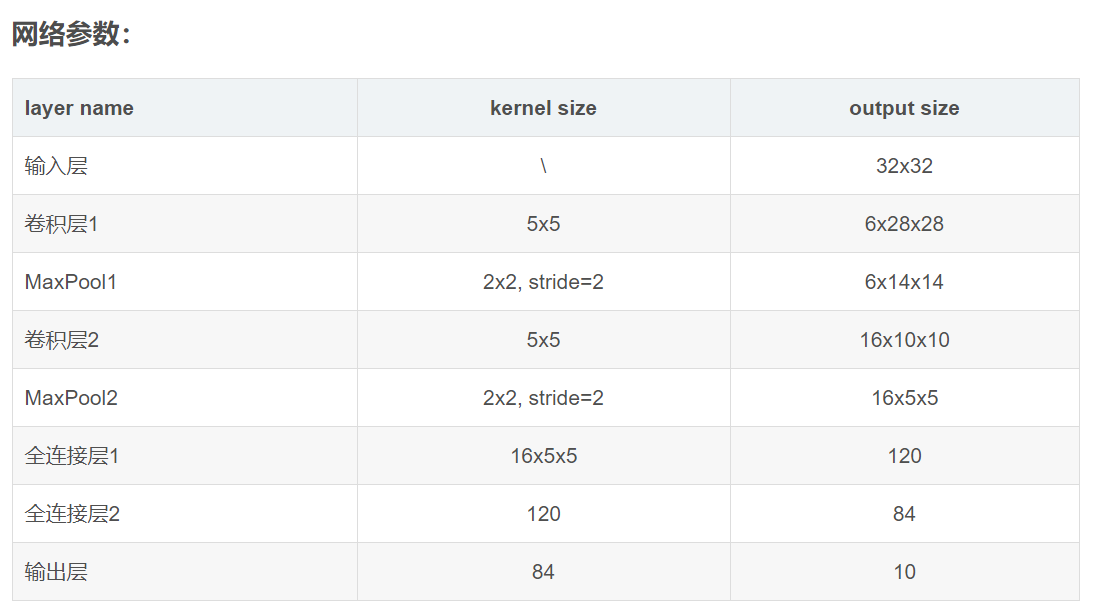

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 由于输入的图片大小不是32*32，而是28*28，所以将 padding=2保证输入输出尺寸相同
        self.conv1 = nn.Sequential(     
            nn.Conv2d(1, 6, 5, 1, 2), 
            nn.ReLU(),      #input_size=(6*28*28)
            nn.MaxPool2d(kernel_size=2, stride=2),#output_size=(6*14*14)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),      #input_size=(16*10*10)
            nn.MaxPool2d(2, 2)  #output_size=(16*5*5)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(84, 10)

    # 定义前向传播过程，输入为x
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


net = LeNet()
print(net)

LeNet(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
  )
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


#### 定义损失函数和优化器

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # 初始化优化器

#### 开始训练

In [5]:
epochs = 2 
def train():
    for epoch in range(epochs):
        sum_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  #将梯度归零
            outputs = net(inputs)  #将数据传入网络进行前向运算
            loss = criterion(outputs, labels)  #得到损失函数
            loss.backward()  #反向传播
            optimizer.step()  #通过梯度做一步参数更新

            # print(loss)
            sum_loss += loss.item()
            if i % 100 == 99:
                print('[%d,%d] loss:%.03f' %
                      (epoch + 1, i + 1, sum_loss / 100))
                sum_loss = 0.0
        with torch.no_grad():
            correct = 0
            total = 0
            for data in test_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum()
            print('第%d个epoch的识别准确率为：%d%%' % (epoch + 1, (100 * correct / total)))
            torch.save(net.state_dict(), 'model_epoch{}.pth'.format(epoch))

In [6]:
train()

[1,100] loss:2.304
[1,200] loss:2.303
[1,300] loss:2.298
[1,400] loss:2.296
[1,500] loss:2.291
[1,600] loss:2.282
[1,700] loss:2.265
[1,800] loss:2.220
[1,900] loss:2.059


..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


第1个epoch的识别准确率为：63%
[2,100] loss:1.175
[2,200] loss:0.732
[2,300] loss:0.573
[2,400] loss:0.496
[2,500] loss:0.471
[2,600] loss:0.440
[2,700] loss:0.392
[2,800] loss:0.357
[2,900] loss:0.348
第2个epoch的识别准确率为：91%
